In [1]:
import torch
import torch.nn as nn
import torch.functional as F

In [2]:
from transformers import RobertaModel, RobertaTokenizer, AutoModel
import importlib


In [3]:
def init_obj(obj_dict, default_module, *args, **kwargs):
    """
    Finds a function handle with the name given as 'type' in config, and returns the
    instance initialized with corresponding arguments given.

    `object = config.init_obj(config['param'], module, a, b=1)`
    is equivalent to
    `object = module.name(a, b=1)`
    """
    if "module" in obj_dict:
        default_module = importlib.import_module(obj_dict["module"])

    module_name = obj_dict["type"]
    module_args = dict(obj_dict["args"])
    assert all(
        [k not in module_args for k in kwargs]
    ), "Overwriting kwargs given in config file is not allowed"
    module_args.update(kwargs)
    return getattr(default_module, module_name)(*args, **module_args)


In [4]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [5]:
text = ["this is a sample text", "another text about lorem ipsum", "rdmtxtsd a sda sd asd afsads"]

In [6]:
text = ["""Lorem ipsum dolor sit amet, consectetur adipiscing elit. Morbi vitae tempus metus. Mauris nec ornare enim, in aliquet nulla. Nunc quis est feugiat, bibendum erat id, malesuada massa. Mauris eu nisi augue. Praesent venenatis vestibulum tellus eget tempor. Cras at bibendum ligula. Morbi fermentum tempus ligula, ac blandit lorem. Suspendisse tincidunt elit id nibh suscipit viverra. Curabitur sit amet sem a eros tempus placerat non eget felis. Phasellus scelerisque id massa ac congue. Nulla tincidunt sapien eu ornare tincidunt.
Duis molestie odio lorem. Vivamus eu tortor eu urna eleifend vestibulum. Pellentesque imperdiet scelerisque orci sit amet sollicitudin. Aenean ut faucibus lorem. Sed eget aliquam arcu, sit amet rhoncus ante. Vivamus eget tempus elit, a dapibus neque. Vivamus vel enim a tortor sodales accumsan. Sed sed est posuere, fringilla tellus quis, interdum ligula. Nunc pretium ut diam ut elementum. Cras nibh magna, egestas vitae nunc at, faucibus tristique augue. Morbi interdum tortor nec elit posuere commodo.
Nullam a tortor iaculis, condimentum elit vel, bibendum enim. Mauris finibus ex vel vestibulum semper. Sed nec tincidunt nibh. Sed euismod turpis nec urna elementum, nec vehicula lorem porttitor. Vivamus nunc magna, finibus sit amet metus aliquet, dapibus malesuada massa. Morbi at sodales sem, vitae porttitor nisl. Etiam nec feugiat eros. Suspendisse venenatis est eget facilisis pellentesque. Morbi vel scelerisque velit, a aliquet turpis. Fusce condimentum est diam, ut blandit massa porttitor in. Aliquam placerat nisi quis vestibulum dignissim. Aliquam erat volutpat. Ut erat magna, scelerisque non ultrices ut, scelerisque id velit. Quisque cursus ipsum sodales egestas consequat. In eu nisi nec quam hendrerit vestibulum eget sed eros. Quisque mollis suscipit laoreet.

Nunc ut odio posuere, lobortis velit id, maximus risus. Quisque finibus dui id diam gravida, quis bibendum metus luctus. Vivamus quis ullamcorper orci, in pulvinar orci. Proin ut lorem quam. Maecenas consequat nisl lorem, eu pretium augue suscipit vel. Maecenas justo libero, hendrerit at aliquam non, varius interdum elit. Donec laoreet eros eu purus eleifend, nec faucibus lorem pellentesque. Etiam a nibh viverra, luctus ex sed, tristique odio. Curabitur non libero aliquam, luctus erat eget, eleifend diam. Integer vitae ultricies nunc, nec efficitur odio. Morbi dapibus enim et velit feugiat mollis. Fusce facilisis porttitor felis vitae vulputate. Mauris neque nibh, pharetra id augue et, sodales condimentum mi. Sed interdum elit vitae sem ultrices, vitae convallis leo iaculis. Ut varius sapien eu tortor facilisis vulputate. Curabitur mollis, mauris nec accumsan pellentesque, metus massa feugiat quam, sagittis pretium nulla mauris at risus.

Fusce laoreet feugiat enim nec dignissim. Proin pulvinar, risus a efficitur iaculis, mi massa iaculis elit, vel viverra odio neque suscipit tortor. Donec faucibus, dui quis sodales ullamcorper, ex lacus volutpat diam, in mattis arcu ante vel lacus. Cras rutrum, nisi et condimentum pulvinar, lorem nulla dapibus elit, a blandit tortor felis a sem. Sed tristique quam quis venenatis scelerisque. Etiam venenatis est at tempus dignissim. Vestibulum luctus, libero a venenatis rhoncus, lacus nibh mattis est, at eleifend risus ex a purus. Proin sodales placerat lorem, at feugiat risus. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Aliquam porta ex fringilla, ultricies neque nec, aliquet sem. Fusce faucibus rutrum pulvinar. Mauris vehicula erat dui, id blandit mauris molestie sit amet.

Sed pellentesque at libero quis semper. Nullam ornare felis quis dolor convallis, ac pretium dui dictum. In ullamcorper, nisi nec efficitur tempor, libero odio euismod ex, venenatis malesuada dui ex a purus. Duis scelerisque, nunc eu scelerisque venenatis, massa neque porttitor metus, euismod posuere velit est nec lorem. Duis luctus sit amet mi eleifend pellentesque. Ut sed ipsum faucibus sapien eleifend accumsan sit amet vel nisl. Praesent eu pharetra ex. Nullam volutpat dictum odio quis porttitor. Pellentesque placerat mollis magna, a sagittis sapien feugiat nec. Nam vel dui vel nunc pellentesque scelerisque at et nunc. Proin in fringilla augue.

Vestibulum rutrum tempor nisi. Donec vel sem aliquet ante consequat rutrum. Pellentesque odio ante, varius sit amet nulla at, ultricies tempor turpis. Interdum et malesuada fames ac ante ipsum primis in faucibus. Pellentesque ultrices, neque non facilisis mollis, urna velit ultricies metus, eu ullamcorper turpis risus in ipsum. Morbi eleifend quis odio nec tincidunt. Duis ut nunc tellus. Phasellus sit amet ex non mauris molestie consectetur. Quisque viverra iaculis euismod. Aliquam a est nulla. Integer id lorem lacus. In varius, tortor vitae volutpat semper, massa magna pulvinar massa, id scelerisque risus magna ac lectus. Curabitur sit amet lacus vestibulum, interdum dui molestie, mollis risus. Aliquam consectetur aliquam enim, porttitor dignissim mi lacinia et. Vestibulum efficitur ac mi non tempor.

Aliquam erat volutpat. Duis vel semper ex. Fusce vehicula sit amet nisi ac fermentum. Aenean luctus, enim vel consectetur rhoncus, felis ipsum sagittis turpis, et consectetur nisi tortor ut tellus. In vitae venenatis libero. Proin efficitur luctus interdum. Vivamus nulla dui, auctor vel vulputate at, hendrerit at nisl. Suspendisse mauris metus, ornare in malesuada eu, aliquet non nunc.

Etiam purus nibh, consectetur sed odio id, scelerisque pellentesque nunc. Pellentesque vestibulum porta lobortis. In hac habitasse platea dictumst. Nulla lectus ipsum, fermentum ut suscipit at, vestibulum ac velit. Duis id ante odio. Sed varius convallis justo, quis rhoncus felis porta at. Sed et libero auctor, semper ante ut, ultricies libero. Ut consequat nulla at dui laoreet porta. Quisque pharetra ante placerat ex malesuada finibus. Maecenas nec turpis sed turpis vehicula blandit quis ac purus. Duis non condimentum ligula, at dignissim ex. Vivamus tincidunt vehicula sapien, a gravida arcu molestie tempus. Nunc venenatis sem id sapien ullamcorper porta.

Sed quis lacinia nisl. In sed sollicitudin metus, id porttitor neque. Suspendisse suscipit vitae ex non consectetur. Nam quis sem ut justo aliquet fringilla. Etiam ut lectus lacinia, pretium risus in, sodales nibh. Aliquam vehicula justo lobortis metus imperdiet egestas. Nullam tincidunt fermentum nunc. Curabitur ac molestie est. Etiam eget ornare orci. Phasellus mattis mollis nisl nec pharetra. Curabitur a quam id sem fermentum pharetra vitae eu ligula. Integer pulvinar, sapien vel suscipit mattis, elit nibh posuere sem, non faucibus justo leo condimentum dui. Vivamus eu mollis est. Nullam suscipit hendrerit lorem interdum laoreet. """, """

Integer a elit lacus. Nulla ut nunc sit amet quam euismod auctor ac porttitor tortor. Aliquam massa dolor, sodales vitae odio sed, aliquam interdum justo. Pellentesque sed iaculis quam, in dignissim sem. Sed pulvinar dignissim rutrum. Aliquam erat volutpat. Donec eu mauris vel leo rutrum elementum. Maecenas malesuada laoreet lorem, eu tempor lectus imperdiet nec. Morbi vitae sagittis arcu, eget bibendum erat. Suspendisse mauris felis, dictum ac urna vel, auctor ultrices eros. Cras lectus libero, imperdiet ut placerat quis, iaculis eget nisl. Phasellus malesuada facilisis fringilla. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Quisque nulla mi, vehicula sit amet tellus nec, consectetur blandit lectus. Cras laoreet viverra ex, eu convallis elit.

Nulla placerat, nulla sit amet tristique commodo, nulla eros mattis nisl, eget porta elit leo a orci. Donec egestas velit sit amet fringilla molestie. In in gravida lacus. Nulla facilisi. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Curabitur vitae sollicitudin arcu. Donec feugiat metus nisl, vel varius augue posuere nec.

Aliquam vulputate varius semper. Nunc id semper eros. Nulla convallis, magna quis pulvinar cursus, turpis orci molestie nibh, non tincidunt nibh erat in tellus. Aenean ultricies turpis non arcu tempus consectetur. Fusce mattis massa vel bibendum maximus. Phasellus ut faucibus sem. Donec viverra ultricies dui, sit amet interdum lectus euismod in. Vivamus id neque vel turpis ullamcorper dignissim vel quis arcu. Integer imperdiet dapibus ex, sed cursus mauris imperdiet nec. Cras nisi augue, scelerisque ac enim venenatis, varius porta massa. Fusce vulputate rutrum nisi, vel pharetra augue molestie id. Aliquam dapibus et ante in hendrerit. Phasellus maximus felis at enim egestas, sit amet tincidunt ligula pulvinar. Praesent at pulvinar justo, quis tincidunt purus.

Etiam a nibh nec sem venenatis vulputate non vulputate urna. Aliquam vulputate ex eget neque elementum mollis. Donec et mauris a magna sodales vehicula at elementum urna. Donec id augue at mauris rhoncus laoreet non nec augue. Pellentesque ornare leo vel nulla laoreet, sed fringilla enim vehicula. Vestibulum auctor ante in tellus lacinia, nec dictum nulla pretium. Integer id ex ligula. Duis sed massa quis est facilisis lacinia fringilla id dolor.

In vitae ultricies velit. In pretium ultricies nibh eu dictum. Donec consequat convallis ex nec finibus. Nam at felis scelerisque tortor fringilla aliquam ac sit amet ipsum. Etiam vulputate metus vel sapien laoreet, eget sagittis sem volutpat. In vehicula scelerisque aliquam. Curabitur feugiat imperdiet eros id laoreet. Aenean ut quam ac nisl mattis vulputate mollis nec nibh. Fusce nec ipsum sed dolor efficitur tempus a vitae arcu. Etiam lobortis dictum dolor, non molestie magna. Maecenas vel felis libero. Cras in diam nisl. Sed et sapien augue.

Ut gravida lacus quis orci sagittis, vitae dignissim elit suscipit. Quisque tempus consequat magna, id mattis sem elementum fringilla. Donec a elit condimentum, dignissim leo non, pulvinar enim. Vivamus velit tellus, interdum rhoncus pretium non, euismod a purus. Nullam cursus et urna id iaculis. Nullam laoreet, tellus non ornare convallis, mi urna molestie mi, quis fermentum velit libero nec ipsum. Cras turpis purus, interdum vitae libero efficitur, pulvinar rhoncus ex. Sed libero mi, ultrices quis bibendum nec, posuere sit amet nunc. Duis malesuada, elit id vestibulum tristique, arcu erat sagittis urna, vel volutpat libero purus non quam. Sed sollicitudin purus at justo lobortis congue eu nec diam. Mauris rhoncus dui erat, vitae tempor elit molestie ac.

Morbi id odio lacus. Donec vitae augue cursus, ullamcorper nibh eu, finibus est. Curabitur efficitur aliquam ipsum quis fringilla. Suspendisse viverra mauris a risus pellentesque iaculis. Cras non commodo lorem. Nam sed risus nunc. Nulla auctor, dolor at ultricies cursus, augue mauris cursus nunc, a volutpat lacus quam id lectus. In ut erat eget dolor facilisis tincidunt vitae ac eros. Suspendisse ac interdum arcu. Proin ac libero sed tortor vehicula efficitur. Nam placerat eleifend lectus in fermentum.

Sed semper fermentum condimentum. Mauris aliquet cursus volutpat. Etiam ut neque ac arcu aliquam elementum sed eu lectus. Sed hendrerit orci tortor, sit amet convallis tortor aliquet eget. Etiam sit amet augue dictum arcu auctor cursus. In hac habitasse platea dictumst. Suspendisse potenti. Quisque sodales, dui eget vulputate interdum, diam nibh rhoncus enim, ac ultricies augue metus sed quam. Etiam consequat lorem mi, sed suscipit tortor malesuada et. Nunc id fermentum justo. Vivamus eleifend, libero sit amet luctus efficitur, sem sem interdum augue, vel mollis magna purus nec diam. Praesent tempus, velit at dignissim vulputate, risus elit consequat ligula, non ullamcorper nulla eros vel enim. Donec laoreet felis eget odio pretium convallis. Suspendisse ut ultrices nisl, ut mollis sapien. Morbi et condimentum ipsum. In id ante eu massa convallis facilisis eu at elit.

Quisque sit amet venenatis arcu. Duis dignissim eros quis urna vestibulum semper. Donec malesuada libero vitae dolor sodales ultrices. Curabitur pellentesque ullamcorper est sed interdum. Praesent ac leo nunc. Sed pretium elit congue tincidunt dictum. Nulla maximus scelerisque nibh, nec malesuada urna ullamcorper sed. Ut eget ante neque. Fusce vitae euismod augue, mattis porta justo. Donec consectetur ipsum quis urna eleifend, at sollicitudin risus dapibus.

Etiam massa risus, feugiat ac purus in, rhoncus facilisis urna. Donec dictum commodo faucibus. Donec quis ligula commodo, auctor tellus sit amet, lacinia magna. Donec pharetra elit at lacus finibus viverra. Cras id ante ut ex semper volutpat. Sed finibus ex sed nisi egestas aliquet. Vestibulum a eros ornare, hendrerit augue nec, molestie quam. Duis ante eros, consectetur at mollis nec, ultricies in leo.

Vestibulum ultricies ipsum metus. Interdum et malesuada fames ac ante ipsum primis in faucibus. In hac habitasse platea dictumst. Aliquam ultricies arcu id erat dignissim, maximus ultrices metus placerat. Vestibulum congue elit mauris, eu vehicula erat tincidunt ac. Nunc nisi lacus, blandit id arcu non, luctus porta augue. Pellentesque in elit eget orci facilisis faucibus sit amet non velit.

Nunc non suscipit turpis. Pellentesque accumsan tempus nulla, ut volutpat quam fermentum sed. Quisque rhoncus justo sodales sem ultrices, sit amet dictum nunc aliquet. Morbi odio sem, eleifend sit amet tellus pulvinar, dignissim dapibus magna. Quisque felis felis, tempor non dictum eget, dignissim vitae elit. Proin a tempor lorem. """, """

Adapted from "The Colors of Animals" by Sir John Lubbock in A Book of Natural History (1902, ed. David Starr Jordan)

The color of animals is by no means a matter of chance; it depends on many considerations, but in the majority of cases tends to protect the animal from danger by rendering it less conspicuous. Perhaps it may be said that if coloring is mainly protective, there ought to be but few brightly colored animals. There are, however, not a few cases in which vivid colors are themselves protective. The kingfisher itself, though so brightly colored, is by no means easy to see. The blue harmonizes with the water, and the bird as it darts along the stream looks almost like a flash of sunlight.

Desert animals are generally the color of the desert. Thus, for instance, the lion, the antelope, and the wild donkey are all sand-colored. “Indeed,” says Canon Tristram, “in the desert, where neither trees, brushwood, nor even undulation of the surface afford the slightest protection to its foes, a modification of color assimilated to that of the surrounding country is absolutely necessary. Hence, without exception, the upper plumage of every bird, and also the fur of all the smaller mammals and the skin of all the snakes and lizards, is of one uniform sand color.”

The next point is the color of the mature caterpillars, some of which are brown. This probably makes the caterpillar even more conspicuous among the green leaves than would otherwise be the case. Let us see, then, whether the habits of the insect will throw any light upon the riddle. What would you do if you were a big caterpillar? Why, like most other defenseless creatures, you would feed by night, and lie concealed by day. So do these caterpillars. When the morning light comes, they creep down the stem of the food plant, and lie concealed among the thick herbage and dry sticks and leaves, near the ground, and it is obvious that under such circumstances the brown color really becomes a protection. It might indeed be argued that the caterpillars, having become brown, concealed themselves on the ground, and that we were reversing the state of things. But this is not so, because, while we may say as a general rule that large caterpillars feed by night and lie concealed by day, it is by no means always the case that they are brown; some of them still retaining the green color. We may then conclude that the habit of concealing themselves by day came first, and that the brown color is a later adaptation.


Adapted from "The Colors of Animals" by Sir John Lubbock in A Book of Natural History (1902, ed. David Starr Jordan)

The color of animals is by no means a matter of chance; it depends on many considerations, but in the majority of cases tends to protect the animal from danger by rendering it less conspicuous. Perhaps it may be said that if coloring is mainly protective, there ought to be but few brightly colored animals. There are, however, not a few cases in which vivid colors are themselves protective. The kingfisher itself, though so brightly colored, is by no means easy to see. The blue harmonizes with the water, and the bird as it darts along the stream looks almost like a flash of sunlight.

Desert animals are generally the color of the desert. Thus, for instance, the lion, the antelope, and the wild donkey are all sand-colored. “Indeed,” says Canon Tristram, “in the desert, where neither trees, brushwood, nor even undulation of the surface afford the slightest protection to its foes, a modification of color assimilated to that of the surrounding country is absolutely necessary. Hence, without exception, the upper plumage of every bird, and also the fur of all the smaller mammals and the skin of all the snakes and lizards, is of one uniform sand color.”

The next point is the color of the mature caterpillars, some of which are brown. This probably makes the caterpillar even more conspicuous among the green leaves than would otherwise be the case. Let us see, then, whether the habits of the insect will throw any light upon the riddle. What would you do if you were a big caterpillar? Why, like most other defenseless creatures, you would feed by night, and lie concealed by day. So do these caterpillars. When the morning light comes, they creep down the stem of the food plant, and lie concealed among the thick herbage and dry sticks and leaves, near the ground, and it is obvious that under such circumstances the brown color really becomes a protection. It might indeed be argued that the caterpillars, having become brown, concealed themselves on the ground, and that we were reversing the state of things. But this is not so, because, while we may say as a general rule that large caterpillars feed by night and lie concealed by day, it is by no means always the case that they are brown; some of them still retaining the green color. We may then conclude that the habit of concealing themselves by day came first, and that the brown color is a later adaptation.
 
"""]

In [7]:
ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

In [8]:
ids

{'input_ids': tensor([[    0,   574, 43375,  ...,   579, 24608,     2],
        [    0, 50118, 50118,  ..., 16080,   856,     2],
        [    0, 50118, 50118,  ...,   460,     5,     2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [9]:
from utils import read_json
import models as module_arch

model_config = read_json("./model_configs/cola/finetune_iternorm.json")

model = init_obj(model_config["arch"], module_arch)

/home/xenos/Documents/rocmsetup/gs_whitening/glue/models/layers/blockdiag_butterfly_multiply.py:63: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float16)
/home/xenos/Documents/rocmsetup/gs_whitening/glue/models/layers/blockdiag_butterfly_multiply.py:82: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_bwd
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Changling layer: encoder.layer.0.output.LayerNorm
Changling layer: encoder.layer.1.output.LayerNorm
Changling layer: encoder.layer.2.output.LayerNorm
Changling layer: encoder.layer.3.output.LayerNorm
Changling layer: encoder.layer.4.output.LayerNorm
Changling layer: encoder.layer.5.output.LayerNorm
Changling layer: encoder.layer.6.output.LayerNorm
Changling layer: encoder.layer.7.output.LayerNorm
Changling layer: encoder.layer.8.output.LayerNorm
Changling layer: encoder.layer.9.output.LayerNorm
Changling layer: encoder.layer.10.output.LayerNorm
Changling layer: encoder.layer.11.output.LayerNorm
Setting hook on layer:embeddings.LayerNorm
Setting hook on layer:encoder.layer.0.output.LayerNorm
Setting hook on layer:encoder.layer.1.output.LayerNorm
Setting hook on layer:encoder.layer.2.output.LayerNorm
Setting hook on layer:encoder.layer.3.output.LayerNorm
Setting hook on layer:encoder.layer.4.output.LayerNorm
Setting hook on layer:encoder.layer.5.output.LayerNorm
Setting hook on layer:enc

In [10]:
C = model(**ids, labels=torch.tensor([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]))

Matrix Sign Whitening

In [11]:
# 10 iters
model.eff_ranks

{'train/input_embeddings.LayerNorm_eff_rank': 5.193336009979248,
 'train/output_embeddings.LayerNorm_eff_rank': 8.175002098083496,
 'train/input_encoder.layer.0.output.LayerNorm_eff_rank': 3.1917850971221924,
 'train/output_encoder.layer.0.output.LayerNorm_eff_rank': 1.1357003450393677,
 'train/input_encoder.layer.1.output.LayerNorm_eff_rank': 1.0132523775100708,
 'train/output_encoder.layer.1.output.LayerNorm_eff_rank': 37.454463958740234,
 'train/input_encoder.layer.2.output.LayerNorm_eff_rank': 1.4413022994995117,
 'train/output_encoder.layer.2.output.LayerNorm_eff_rank': 7.32688570022583,
 'train/input_encoder.layer.3.output.LayerNorm_eff_rank': 1.047258734703064,
 'train/output_encoder.layer.3.output.LayerNorm_eff_rank': 6.239782333374023,
 'train/input_encoder.layer.4.output.LayerNorm_eff_rank': 1.0386852025985718,
 'train/output_encoder.layer.4.output.LayerNorm_eff_rank': 4.371671676635742,
 'train/input_encoder.layer.5.output.LayerNorm_eff_rank': 1.0842208862304688,
 'train/out

In [11]:
# 5 iters
model.eff_ranks

{'train/input_embeddings.LayerNorm_eff_rank': 5.193336486816406,
 'train/output_embeddings.LayerNorm_eff_rank': 8.175002098083496,
 'train/input_encoder.layer.0.output.LayerNorm_eff_rank': 3.1917850971221924,
 'train/output_encoder.layer.0.output.LayerNorm_eff_rank': 1.010988712310791,
 'train/input_encoder.layer.1.output.LayerNorm_eff_rank': 1.0012658834457397,
 'train/output_encoder.layer.1.output.LayerNorm_eff_rank': 5.299077987670898,
 'train/input_encoder.layer.2.output.LayerNorm_eff_rank': 1.102602481842041,
 'train/output_encoder.layer.2.output.LayerNorm_eff_rank': 2.3205692768096924,
 'train/input_encoder.layer.3.output.LayerNorm_eff_rank': 1.013131856918335,
 'train/output_encoder.layer.3.output.LayerNorm_eff_rank': 3.404017686843872,
 'train/input_encoder.layer.4.output.LayerNorm_eff_rank': 1.0238844156265259,
 'train/output_encoder.layer.4.output.LayerNorm_eff_rank': 1.025109887123108,
 'train/input_encoder.layer.5.output.LayerNorm_eff_rank': 1.0016363859176636,
 'train/outp

Default IterNorm whitening

In [11]:
# 5 iters
model.eff_ranks

{'train/input_embeddings.LayerNorm_eff_rank': 5.19333553314209,
 'train/output_embeddings.LayerNorm_eff_rank': 8.175002098083496,
 'train/input_encoder.layer.0.output.LayerNorm_eff_rank': 3.1917850971221924,
 'train/output_encoder.layer.0.output.LayerNorm_eff_rank': 3.0840723514556885,
 'train/input_encoder.layer.1.output.LayerNorm_eff_rank': 1.2203234434127808,
 'train/output_encoder.layer.1.output.LayerNorm_eff_rank': 11.248404502868652,
 'train/input_encoder.layer.2.output.LayerNorm_eff_rank': 1.1964112520217896,
 'train/output_encoder.layer.2.output.LayerNorm_eff_rank': 8.915568351745605,
 'train/input_encoder.layer.3.output.LayerNorm_eff_rank': 1.0765827894210815,
 'train/output_encoder.layer.3.output.LayerNorm_eff_rank': 2.947589874267578,
 'train/input_encoder.layer.4.output.LayerNorm_eff_rank': 1.025378704071045,
 'train/output_encoder.layer.4.output.LayerNorm_eff_rank': 5.898233890533447,
 'train/input_encoder.layer.5.output.LayerNorm_eff_rank': 1.1456935405731201,
 'train/out

In [11]:
model.eff_ranks

{'train/input_embeddings.LayerNorm_eff_rank': 5.193336009979248,
 'train/output_embeddings.LayerNorm_eff_rank': 8.175002098083496,
 'train/input_encoder.layer.0.output.LayerNorm_eff_rank': 3.1917848587036133,
 'train/output_encoder.layer.0.output.LayerNorm_eff_rank': 2.003002882003784,
 'train/input_encoder.layer.1.output.LayerNorm_eff_rank': 1.109137773513794,
 'train/output_encoder.layer.1.output.LayerNorm_eff_rank': 3.831195592880249,
 'train/input_encoder.layer.2.output.LayerNorm_eff_rank': 1.1440984010696411,
 'train/output_encoder.layer.2.output.LayerNorm_eff_rank': 2.3001413345336914,
 'train/input_encoder.layer.3.output.LayerNorm_eff_rank': 1.0161973237991333,
 'train/output_encoder.layer.3.output.LayerNorm_eff_rank': 1.139228343963623,
 'train/input_encoder.layer.4.output.LayerNorm_eff_rank': 1.0581029653549194,
 'train/output_encoder.layer.4.output.LayerNorm_eff_rank': 1.157272458076477,
 'train/input_encoder.layer.5.output.LayerNorm_eff_rank': 1.0088953971862793,
 'train/out

In [14]:
loss = C["loss"]

In [15]:
loss.backward()

In [16]:
model.zero_grad()

In [10]:
model.attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [18]:
model.roberta.encoder.layer[0].output.LayerNorm.attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [14]:
loss = model(**ids, labels=torch.tensor([[0.0, 1.0], [1.0, 0.0], [0.0, 1.0]]))["loss"]

In [15]:
loss.backward()

In [16]:
for name, param in model.named_parameters():
    print(name, param.grad)
    break

roberta.embeddings.word_embeddings.weight tensor([[ 3.3131e-04,  1.4984e-04, -2.3676e-04,  ...,  2.4388e-04,
         -2.5710e-04,  1.8857e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 7.5281e-04,  1.3881e-04, -5.7799e-05,  ..., -2.3987e-04,
          3.0061e-04,  6.7412e-04],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [3]:
from transformers import RobertaModel, RobertaTokenizer

model = RobertaModel.from_pretrained("roberta-base")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
text = ["""Lorem ipsum dolor sit amet, consectetur adipiscing elit. Morbi vitae tempus metus. Mauris nec ornare enim, in aliquet nulla. Nunc quis est feugiat, bibendum erat id, malesuada massa. Mauris eu nisi augue. Praesent venenatis vestibulum tellus eget tempor. Cras at bibendum ligula. Morbi fermentum tempus ligula, ac blandit lorem. Suspendisse tincidunt elit id nibh suscipit viverra. Curabitur sit amet sem a eros tempus placerat non eget felis. Phasellus scelerisque id massa ac congue. Nulla tincidunt sapien eu ornare tincidunt.
Duis molestie odio lorem. Vivamus eu tortor eu urna eleifend vestibulum. Pellentesque imperdiet scelerisque orci sit amet sollicitudin. Aenean ut faucibus lorem. Sed eget aliquam arcu, sit amet rhoncus ante. Vivamus eget tempus elit, a dapibus neque. Vivamus vel enim a tortor sodales accumsan. Sed sed est posuere, fringilla tellus quis, interdum ligula. Nunc pretium ut diam ut elementum. Cras nibh magna, egestas vitae nunc at, faucibus tristique augue. Morbi interdum tortor nec elit posuere commodo.
Nullam a tortor iaculis, condimentum elit vel, bibendum enim. Mauris finibus ex vel vestibulum semper. Sed nec tincidunt nibh. Sed euismod turpis nec urna elementum, nec vehicula lorem porttitor. Vivamus nunc magna, finibus sit amet metus aliquet, dapibus malesuada massa. Morbi at sodales sem, vitae porttitor nisl. Etiam nec feugiat eros. Suspendisse venenatis est eget facilisis pellentesque. Morbi vel scelerisque velit, a aliquet turpis. Fusce condimentum est diam, ut blandit massa porttitor in. Aliquam placerat nisi quis vestibulum dignissim. Aliquam erat volutpat. Ut erat magna, scelerisque non ultrices ut, scelerisque id velit. Quisque cursus ipsum sodales egestas consequat. In eu nisi nec quam hendrerit vestibulum eget sed eros. Quisque mollis suscipit laoreet.

Nunc ut odio posuere, lobortis velit id, maximus risus. Quisque finibus dui id diam gravida, quis bibendum metus luctus. Vivamus quis ullamcorper orci, in pulvinar orci. Proin ut lorem quam. Maecenas consequat nisl lorem, eu pretium augue suscipit vel. Maecenas justo libero, hendrerit at aliquam non, varius interdum elit. Donec laoreet eros eu purus eleifend, nec faucibus lorem pellentesque. Etiam a nibh viverra, luctus ex sed, tristique odio. Curabitur non libero aliquam, luctus erat eget, eleifend diam. Integer vitae ultricies nunc, nec efficitur odio. Morbi dapibus enim et velit feugiat mollis. Fusce facilisis porttitor felis vitae vulputate. Mauris neque nibh, pharetra id augue et, sodales condimentum mi. Sed interdum elit vitae sem ultrices, vitae convallis leo iaculis. Ut varius sapien eu tortor facilisis vulputate. Curabitur mollis, mauris nec accumsan pellentesque, metus massa feugiat quam, sagittis pretium nulla mauris at risus.

Fusce laoreet feugiat enim nec dignissim. Proin pulvinar, risus a efficitur iaculis, mi massa iaculis elit, vel viverra odio neque suscipit tortor. Donec faucibus, dui quis sodales ullamcorper, ex lacus volutpat diam, in mattis arcu ante vel lacus. Cras rutrum, nisi et condimentum pulvinar, lorem nulla dapibus elit, a blandit tortor felis a sem. Sed tristique quam quis venenatis scelerisque. Etiam venenatis est at tempus dignissim. Vestibulum luctus, libero a venenatis rhoncus, lacus nibh mattis est, at eleifend risus ex a purus. Proin sodales placerat lorem, at feugiat risus. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Aliquam porta ex fringilla, ultricies neque nec, aliquet sem. Fusce faucibus rutrum pulvinar. Mauris vehicula erat dui, id blandit mauris molestie sit amet.

Sed pellentesque at libero quis semper. Nullam ornare felis quis dolor convallis, ac pretium dui dictum. In ullamcorper, nisi nec efficitur tempor, libero odio euismod ex, venenatis malesuada dui ex a purus. Duis scelerisque, nunc eu scelerisque venenatis, massa neque porttitor metus, euismod posuere velit est nec lorem. Duis luctus sit amet mi eleifend pellentesque. Ut sed ipsum faucibus sapien eleifend accumsan sit amet vel nisl. Praesent eu pharetra ex. Nullam volutpat dictum odio quis porttitor. Pellentesque placerat mollis magna, a sagittis sapien feugiat nec. Nam vel dui vel nunc pellentesque scelerisque at et nunc. Proin in fringilla augue.

Vestibulum rutrum tempor nisi. Donec vel sem aliquet ante consequat rutrum. Pellentesque odio ante, varius sit amet nulla at, ultricies tempor turpis. Interdum et malesuada fames ac ante ipsum primis in faucibus. Pellentesque ultrices, neque non facilisis mollis, urna velit ultricies metus, eu ullamcorper turpis risus in ipsum. Morbi eleifend quis odio nec tincidunt. Duis ut nunc tellus. Phasellus sit amet ex non mauris molestie consectetur. Quisque viverra iaculis euismod. Aliquam a est nulla. Integer id lorem lacus. In varius, tortor vitae volutpat semper, massa magna pulvinar massa, id scelerisque risus magna ac lectus. Curabitur sit amet lacus vestibulum, interdum dui molestie, mollis risus. Aliquam consectetur aliquam enim, porttitor dignissim mi lacinia et. Vestibulum efficitur ac mi non tempor.

Aliquam erat volutpat. Duis vel semper ex. Fusce vehicula sit amet nisi ac fermentum. Aenean luctus, enim vel consectetur rhoncus, felis ipsum sagittis turpis, et consectetur nisi tortor ut tellus. In vitae venenatis libero. Proin efficitur luctus interdum. Vivamus nulla dui, auctor vel vulputate at, hendrerit at nisl. Suspendisse mauris metus, ornare in malesuada eu, aliquet non nunc.

Etiam purus nibh, consectetur sed odio id, scelerisque pellentesque nunc. Pellentesque vestibulum porta lobortis. In hac habitasse platea dictumst. Nulla lectus ipsum, fermentum ut suscipit at, vestibulum ac velit. Duis id ante odio. Sed varius convallis justo, quis rhoncus felis porta at. Sed et libero auctor, semper ante ut, ultricies libero. Ut consequat nulla at dui laoreet porta. Quisque pharetra ante placerat ex malesuada finibus. Maecenas nec turpis sed turpis vehicula blandit quis ac purus. Duis non condimentum ligula, at dignissim ex. Vivamus tincidunt vehicula sapien, a gravida arcu molestie tempus. Nunc venenatis sem id sapien ullamcorper porta.

Sed quis lacinia nisl. In sed sollicitudin metus, id porttitor neque. Suspendisse suscipit vitae ex non consectetur. Nam quis sem ut justo aliquet fringilla. Etiam ut lectus lacinia, pretium risus in, sodales nibh. Aliquam vehicula justo lobortis metus imperdiet egestas. Nullam tincidunt fermentum nunc. Curabitur ac molestie est. Etiam eget ornare orci. Phasellus mattis mollis nisl nec pharetra. Curabitur a quam id sem fermentum pharetra vitae eu ligula. Integer pulvinar, sapien vel suscipit mattis, elit nibh posuere sem, non faucibus justo leo condimentum dui. Vivamus eu mollis est. Nullam suscipit hendrerit lorem interdum laoreet. """, """

Integer a elit lacus. Nulla ut nunc sit amet quam euismod auctor ac porttitor tortor. Aliquam massa dolor, sodales vitae odio sed, aliquam interdum justo. Pellentesque sed iaculis quam, in dignissim sem. Sed pulvinar dignissim rutrum. Aliquam erat volutpat. Donec eu mauris vel leo rutrum elementum. Maecenas malesuada laoreet lorem, eu tempor lectus imperdiet nec. Morbi vitae sagittis arcu, eget bibendum erat. Suspendisse mauris felis, dictum ac urna vel, auctor ultrices eros. Cras lectus libero, imperdiet ut placerat quis, iaculis eget nisl. Phasellus malesuada facilisis fringilla. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Quisque nulla mi, vehicula sit amet tellus nec, consectetur blandit lectus. Cras laoreet viverra ex, eu convallis elit.

Nulla placerat, nulla sit amet tristique commodo, nulla eros mattis nisl, eget porta elit leo a orci. Donec egestas velit sit amet fringilla molestie. In in gravida lacus. Nulla facilisi. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Curabitur vitae sollicitudin arcu. Donec feugiat metus nisl, vel varius augue posuere nec.

Aliquam vulputate varius semper. Nunc id semper eros. Nulla convallis, magna quis pulvinar cursus, turpis orci molestie nibh, non tincidunt nibh erat in tellus. Aenean ultricies turpis non arcu tempus consectetur. Fusce mattis massa vel bibendum maximus. Phasellus ut faucibus sem. Donec viverra ultricies dui, sit amet interdum lectus euismod in. Vivamus id neque vel turpis ullamcorper dignissim vel quis arcu. Integer imperdiet dapibus ex, sed cursus mauris imperdiet nec. Cras nisi augue, scelerisque ac enim venenatis, varius porta massa. Fusce vulputate rutrum nisi, vel pharetra augue molestie id. Aliquam dapibus et ante in hendrerit. Phasellus maximus felis at enim egestas, sit amet tincidunt ligula pulvinar. Praesent at pulvinar justo, quis tincidunt purus.

Etiam a nibh nec sem venenatis vulputate non vulputate urna. Aliquam vulputate ex eget neque elementum mollis. Donec et mauris a magna sodales vehicula at elementum urna. Donec id augue at mauris rhoncus laoreet non nec augue. Pellentesque ornare leo vel nulla laoreet, sed fringilla enim vehicula. Vestibulum auctor ante in tellus lacinia, nec dictum nulla pretium. Integer id ex ligula. Duis sed massa quis est facilisis lacinia fringilla id dolor.

In vitae ultricies velit. In pretium ultricies nibh eu dictum. Donec consequat convallis ex nec finibus. Nam at felis scelerisque tortor fringilla aliquam ac sit amet ipsum. Etiam vulputate metus vel sapien laoreet, eget sagittis sem volutpat. In vehicula scelerisque aliquam. Curabitur feugiat imperdiet eros id laoreet. Aenean ut quam ac nisl mattis vulputate mollis nec nibh. Fusce nec ipsum sed dolor efficitur tempus a vitae arcu. Etiam lobortis dictum dolor, non molestie magna. Maecenas vel felis libero. Cras in diam nisl. Sed et sapien augue.

Ut gravida lacus quis orci sagittis, vitae dignissim elit suscipit. Quisque tempus consequat magna, id mattis sem elementum fringilla. Donec a elit condimentum, dignissim leo non, pulvinar enim. Vivamus velit tellus, interdum rhoncus pretium non, euismod a purus. Nullam cursus et urna id iaculis. Nullam laoreet, tellus non ornare convallis, mi urna molestie mi, quis fermentum velit libero nec ipsum. Cras turpis purus, interdum vitae libero efficitur, pulvinar rhoncus ex. Sed libero mi, ultrices quis bibendum nec, posuere sit amet nunc. Duis malesuada, elit id vestibulum tristique, arcu erat sagittis urna, vel volutpat libero purus non quam. Sed sollicitudin purus at justo lobortis congue eu nec diam. Mauris rhoncus dui erat, vitae tempor elit molestie ac.

Morbi id odio lacus. Donec vitae augue cursus, ullamcorper nibh eu, finibus est. Curabitur efficitur aliquam ipsum quis fringilla. Suspendisse viverra mauris a risus pellentesque iaculis. Cras non commodo lorem. Nam sed risus nunc. Nulla auctor, dolor at ultricies cursus, augue mauris cursus nunc, a volutpat lacus quam id lectus. In ut erat eget dolor facilisis tincidunt vitae ac eros. Suspendisse ac interdum arcu. Proin ac libero sed tortor vehicula efficitur. Nam placerat eleifend lectus in fermentum.

Sed semper fermentum condimentum. Mauris aliquet cursus volutpat. Etiam ut neque ac arcu aliquam elementum sed eu lectus. Sed hendrerit orci tortor, sit amet convallis tortor aliquet eget. Etiam sit amet augue dictum arcu auctor cursus. In hac habitasse platea dictumst. Suspendisse potenti. Quisque sodales, dui eget vulputate interdum, diam nibh rhoncus enim, ac ultricies augue metus sed quam. Etiam consequat lorem mi, sed suscipit tortor malesuada et. Nunc id fermentum justo. Vivamus eleifend, libero sit amet luctus efficitur, sem sem interdum augue, vel mollis magna purus nec diam. Praesent tempus, velit at dignissim vulputate, risus elit consequat ligula, non ullamcorper nulla eros vel enim. Donec laoreet felis eget odio pretium convallis. Suspendisse ut ultrices nisl, ut mollis sapien. Morbi et condimentum ipsum. In id ante eu massa convallis facilisis eu at elit.

Quisque sit amet venenatis arcu. Duis dignissim eros quis urna vestibulum semper. Donec malesuada libero vitae dolor sodales ultrices. Curabitur pellentesque ullamcorper est sed interdum. Praesent ac leo nunc. Sed pretium elit congue tincidunt dictum. Nulla maximus scelerisque nibh, nec malesuada urna ullamcorper sed. Ut eget ante neque. Fusce vitae euismod augue, mattis porta justo. Donec consectetur ipsum quis urna eleifend, at sollicitudin risus dapibus.

Etiam massa risus, feugiat ac purus in, rhoncus facilisis urna. Donec dictum commodo faucibus. Donec quis ligula commodo, auctor tellus sit amet, lacinia magna. Donec pharetra elit at lacus finibus viverra. Cras id ante ut ex semper volutpat. Sed finibus ex sed nisi egestas aliquet. Vestibulum a eros ornare, hendrerit augue nec, molestie quam. Duis ante eros, consectetur at mollis nec, ultricies in leo.

Vestibulum ultricies ipsum metus. Interdum et malesuada fames ac ante ipsum primis in faucibus. In hac habitasse platea dictumst. Aliquam ultricies arcu id erat dignissim, maximus ultrices metus placerat. Vestibulum congue elit mauris, eu vehicula erat tincidunt ac. Nunc nisi lacus, blandit id arcu non, luctus porta augue. Pellentesque in elit eget orci facilisis faucibus sit amet non velit.

Nunc non suscipit turpis. Pellentesque accumsan tempus nulla, ut volutpat quam fermentum sed. Quisque rhoncus justo sodales sem ultrices, sit amet dictum nunc aliquet. Morbi odio sem, eleifend sit amet tellus pulvinar, dignissim dapibus magna. Quisque felis felis, tempor non dictum eget, dignissim vitae elit. Proin a tempor lorem. """, """

Adapted from "The Colors of Animals" by Sir John Lubbock in A Book of Natural History (1902, ed. David Starr Jordan)

The color of animals is by no means a matter of chance; it depends on many considerations, but in the majority of cases tends to protect the animal from danger by rendering it less conspicuous. Perhaps it may be said that if coloring is mainly protective, there ought to be but few brightly colored animals. There are, however, not a few cases in which vivid colors are themselves protective. The kingfisher itself, though so brightly colored, is by no means easy to see. The blue harmonizes with the water, and the bird as it darts along the stream looks almost like a flash of sunlight.

Desert animals are generally the color of the desert. Thus, for instance, the lion, the antelope, and the wild donkey are all sand-colored. “Indeed,” says Canon Tristram, “in the desert, where neither trees, brushwood, nor even undulation of the surface afford the slightest protection to its foes, a modification of color assimilated to that of the surrounding country is absolutely necessary. Hence, without exception, the upper plumage of every bird, and also the fur of all the smaller mammals and the skin of all the snakes and lizards, is of one uniform sand color.”

The next point is the color of the mature caterpillars, some of which are brown. This probably makes the caterpillar even more conspicuous among the green leaves than would otherwise be the case. Let us see, then, whether the habits of the insect will throw any light upon the riddle. What would you do if you were a big caterpillar? Why, like most other defenseless creatures, you would feed by night, and lie concealed by day. So do these caterpillars. When the morning light comes, they creep down the stem of the food plant, and lie concealed among the thick herbage and dry sticks and leaves, near the ground, and it is obvious that under such circumstances the brown color really becomes a protection. It might indeed be argued that the caterpillars, having become brown, concealed themselves on the ground, and that we were reversing the state of things. But this is not so, because, while we may say as a general rule that large caterpillars feed by night and lie concealed by day, it is by no means always the case that they are brown; some of them still retaining the green color. We may then conclude that the habit of concealing themselves by day came first, and that the brown color is a later adaptation.


Adapted from "The Colors of Animals" by Sir John Lubbock in A Book of Natural History (1902, ed. David Starr Jordan)

The color of animals is by no means a matter of chance; it depends on many considerations, but in the majority of cases tends to protect the animal from danger by rendering it less conspicuous. Perhaps it may be said that if coloring is mainly protective, there ought to be but few brightly colored animals. There are, however, not a few cases in which vivid colors are themselves protective. The kingfisher itself, though so brightly colored, is by no means easy to see. The blue harmonizes with the water, and the bird as it darts along the stream looks almost like a flash of sunlight.

Desert animals are generally the color of the desert. Thus, for instance, the lion, the antelope, and the wild donkey are all sand-colored. “Indeed,” says Canon Tristram, “in the desert, where neither trees, brushwood, nor even undulation of the surface afford the slightest protection to its foes, a modification of color assimilated to that of the surrounding country is absolutely necessary. Hence, without exception, the upper plumage of every bird, and also the fur of all the smaller mammals and the skin of all the snakes and lizards, is of one uniform sand color.”

The next point is the color of the mature caterpillars, some of which are brown. This probably makes the caterpillar even more conspicuous among the green leaves than would otherwise be the case. Let us see, then, whether the habits of the insect will throw any light upon the riddle. What would you do if you were a big caterpillar? Why, like most other defenseless creatures, you would feed by night, and lie concealed by day. So do these caterpillars. When the morning light comes, they creep down the stem of the food plant, and lie concealed among the thick herbage and dry sticks and leaves, near the ground, and it is obvious that under such circumstances the brown color really becomes a protection. It might indeed be argued that the caterpillars, having become brown, concealed themselves on the ground, and that we were reversing the state of things. But this is not so, because, while we may say as a general rule that large caterpillars feed by night and lie concealed by day, it is by no means always the case that they are brown; some of them still retaining the green color. We may then conclude that the habit of concealing themselves by day came first, and that the brown color is a later adaptation.
 
"""]

In [5]:
def _get_attention_mask_hook(name):
    def forward_hook(module, input, output ):

        print(name, len(input), len(output))
        return None
    return forward_hook

In [6]:
for name, module in model.named_modules():
    module.register_forward_hook(_get_attention_mask_hook(name))

In [7]:
text = [x.strip("\n") for x in text]

In [8]:
ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

In [9]:
A = model(**ids).last_hidden_state

embeddings.word_embeddings 1 3
embeddings.token_type_embeddings 1 3
embeddings.position_embeddings 1 3
embeddings.LayerNorm 1 3
embeddings.dropout 1 3
embeddings 0 3
encoder.layer.0.attention.self.query 1 3
encoder.layer.0.attention.self.key 1 3
encoder.layer.0.attention.self.value 1 3
encoder.layer.0.attention.self 7 1
encoder.layer.0.attention.output.dense 1 3
encoder.layer.0.attention.output.dropout 1 3
encoder.layer.0.attention.output.LayerNorm 1 3
encoder.layer.0.attention.output 2 3
encoder.layer.0.attention 3 1
encoder.layer.0.intermediate.dense 1 3
encoder.layer.0.intermediate.intermediate_act_fn 1 3
encoder.layer.0.intermediate 1 3
encoder.layer.0.output.dense 1 3
encoder.layer.0.output.dropout 1 3
encoder.layer.0.output.LayerNorm 1 3
encoder.layer.0.output 2 3
encoder.layer.0 7 1
encoder.layer.1.attention.self.query 1 3
encoder.layer.1.attention.self.key 1 3
encoder.layer.1.attention.self.value 1 3
encoder.layer.1.attention.self 7 1
encoder.layer.1.attention.output.dense 1 3


In [10]:
A = (A * ids["attention_mask"][:, :, None]).detach().clone()

In [56]:
# torch.eye(768, 768).repeat(3, 1, 1) * (A.permute(0, 2, 1)@A).diagonal(offset=0, dim1=-2, dim2=-1)[:, :, None]

In [57]:
import sys
del sys.modules["models.layers.whitening"]

In [58]:
from models.layers.whitening import WhiteningSing2dIterNorm, WhiteningTrace2dIterNorm, WhiteningMatrixSign2dIterNorm
from seaborn import lineplot
import torch

In [59]:
eff_rank = lambda x: torch.linalg.matrix_norm(x, ord="fro", dim=(-2, -1))**2 / torch.linalg.matrix_norm(x, ord=2, dim=(-2, -1))**2

In [60]:
wh1 = lambda x, y, z=False: WhiteningSing2dIterNorm(num_features=768, affine=False, use_running_stats_train=False, use_batch_whitening=False, use_diag_initialization=z, iterations=y, )(x)

In [61]:
wh2 = lambda x, y, z=False: WhiteningTrace2dIterNorm(num_features=768, affine=False, use_running_stats_train=False, use_batch_whitening=False, use_diag_initialization=z, iterations=y)(x)

In [62]:
wh3 = lambda x, y: WhiteningMatrixSign2dIterNorm(num_features=768, affine=False, use_running_stats_train=False, use_batch_whitening=False, iterations=y)(x)

In [63]:
B = torch.randn((1, 10000, 768))

In [64]:
singvals = lambda x: torch.sort(torch.linalg.eigvals((x-x.mean(dim=1, keepdim=True)).permute(0, 2, 1)@(x-x.mean(dim=1, keepdim=True))).real, descending=True).values.mean(dim=0)

In [65]:
(A.reshape(1, -1, 768).permute(0, 2, 1)@A.reshape(1, -1, 768)).mean(dim=0).trace(), (A.reshape(1, -1, 768).permute(0, 2, 1)@A.reshape(1, -1, 768)).diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=1).mean()

(tensor(273396.0312), tensor(273396.))

In [66]:
(A.reshape(1, -1, 768).permute(0, 2, 1)@A.reshape(1, -1, 768)).norm(p="fro", dim=(-2, -1)), A.reshape(1, -1, 768).norm(p="fro", dim=(-2, -1))**2, A.reshape(1, -1, 768).norm(p="fro", dim=(-2, -1))

(tensor([171409.6250]), tensor([273375.4062]), tensor([522.8531]))

In [67]:
(A.reshape(1, -1, 768).permute(0, 2, 1)@A.reshape(1, -1, 768)).diagonal(offset=0, dim1=-2, dim2=-1).sum(-1)

tensor([273396.])

In [68]:
singvals(A.reshape(1, -1, 768)), singvals(A.reshape(1, -1, 768)).sum(), eff_rank(A), eff_rank(A.reshape(1, -1, 768))

(tensor([1.0451e+04, 9.6129e+03, 7.2949e+03, 6.3462e+03, 3.9876e+03, 3.2662e+03,
         2.5261e+03, 2.2057e+03, 2.0297e+03, 1.9238e+03, 1.8620e+03, 1.7766e+03,
         1.6388e+03, 1.5689e+03, 1.4703e+03, 1.3925e+03, 1.3732e+03, 1.3270e+03,
         1.1418e+03, 1.0898e+03, 1.0223e+03, 9.6041e+02, 8.7989e+02, 8.3448e+02,
         8.1996e+02, 8.0587e+02, 7.7270e+02, 7.3866e+02, 7.2003e+02, 6.6666e+02,
         6.6334e+02, 6.2406e+02, 5.9302e+02, 5.5620e+02, 5.5080e+02, 5.3065e+02,
         5.2084e+02, 5.1554e+02, 4.9808e+02, 4.7346e+02, 4.5630e+02, 4.4021e+02,
         4.3379e+02, 4.1307e+02, 4.0171e+02, 3.9148e+02, 3.8977e+02, 3.8795e+02,
         3.6187e+02, 3.5985e+02, 3.5171e+02, 3.4580e+02, 3.3573e+02, 3.2340e+02,
         3.1257e+02, 3.0956e+02, 2.9761e+02, 2.9058e+02, 2.8457e+02, 2.8274e+02,
         2.8167e+02, 2.7655e+02, 2.6807e+02, 2.6040e+02, 2.5073e+02, 2.4387e+02,
         2.3872e+02, 2.3244e+02, 2.2966e+02, 2.2326e+02, 2.2174e+02, 2.1865e+02,
         2.1653e+02, 2.1427e

In [69]:
singvals(B), singvals(B).sum(), eff_rank(B), eff_rank(B.reshape(1, -1, 768))

(tensor([16216.5410, 16106.6865, 16063.0664, 15999.0938, 15920.0391, 15837.3789,
         15786.7578, 15766.6035, 15747.3906, 15683.5771, 15675.2764, 15627.9697,
         15602.1279, 15558.2637, 15528.3457, 15496.7539, 15452.6348, 15440.3252,
         15408.9629, 15397.2109, 15374.0273, 15344.2227, 15301.3682, 15280.0693,
         15255.7842, 15198.5166, 15139.8877, 15131.2402, 15098.4219, 15081.6826,
         15047.6582, 15022.4619, 14987.2715, 14967.3086, 14954.2764, 14909.5830,
         14893.4248, 14860.0654, 14849.4023, 14829.4971, 14818.1797, 14790.5000,
         14768.7861, 14753.5625, 14732.1152, 14702.0459, 14679.2354, 14651.1855,
         14603.8428, 14591.8027, 14570.5596, 14553.4883, 14522.4365, 14490.6426,
         14458.8154, 14435.2344, 14423.6133, 14409.9160, 14406.2832, 14379.3818,
         14353.1162, 14333.9111, 14315.5078, 14303.6816, 14287.5068, 14263.2227,
         14230.5732, 14180.0508, 14170.8662, 14162.2461, 14146.2393, 14127.2383,
         14117.2598, 14093.6

In [70]:
iterations = 0
singvals(wh3(B, iterations, )), singvals(wh3(B, iterations, )).sum()

(tensor([ 1.6233e+04,  1.6125e+04,  1.6070e+04,  1.6016e+04,  1.5938e+04,
          1.5851e+04,  1.5801e+04,  1.5784e+04,  1.5767e+04,  1.5702e+04,
          1.5681e+04,  1.5658e+04,  1.5620e+04,  1.5582e+04,  1.5553e+04,
          1.5508e+04,  1.5469e+04,  1.5456e+04,  1.5427e+04,  1.5420e+04,
          1.5389e+04,  1.5370e+04,  1.5312e+04,  1.5294e+04,  1.5264e+04,
          1.5235e+04,  1.5153e+04,  1.5148e+04,  1.5118e+04,  1.5091e+04,
          1.5056e+04,  1.5041e+04,  1.5012e+04,  1.4985e+04,  1.4947e+04,
          1.4923e+04,  1.4902e+04,  1.4880e+04,  1.4864e+04,  1.4839e+04,
          1.4837e+04,  1.4813e+04,  1.4787e+04,  1.4767e+04,  1.4740e+04,
          1.4708e+04,  1.4692e+04,  1.4663e+04,  1.4621e+04,  1.4604e+04,
          1.4583e+04,  1.4562e+04,  1.4534e+04,  1.4498e+04,  1.4482e+04,
          1.4454e+04,  1.4421e+04,  1.4412e+04,  1.4405e+04,  1.4388e+04,
          1.4365e+04,  1.4358e+04,  1.4328e+04,  1.4312e+04,  1.4305e+04,
          1.4256e+04,  1.4250e+04,  1.

In [71]:
iterations = 3
singvals(wh1(B, iterations, )), singvals(wh1(B, iterations, )).sum()

(tensor([ 1.0300e+04,  1.0295e+04,  1.0289e+04,  1.0286e+04,  1.0286e+04,
          1.0283e+04,  1.0282e+04,  1.0278e+04,  1.0277e+04,  1.0276e+04,
          1.0275e+04,  1.0274e+04,  1.0272e+04,  1.0269e+04,  1.0267e+04,
          1.0266e+04,  1.0265e+04,  1.0263e+04,  1.0262e+04,  1.0260e+04,
          1.0259e+04,  1.0257e+04,  1.0255e+04,  1.0255e+04,  1.0254e+04,
          1.0252e+04,  1.0251e+04,  1.0250e+04,  1.0249e+04,  1.0248e+04,
          1.0247e+04,  1.0246e+04,  1.0244e+04,  1.0242e+04,  1.0241e+04,
          1.0240e+04,  1.0240e+04,  1.0239e+04,  1.0238e+04,  1.0238e+04,
          1.0236e+04,  1.0235e+04,  1.0234e+04,  1.0233e+04,  1.0232e+04,
          1.0231e+04,  1.0231e+04,  1.0229e+04,  1.0228e+04,  1.0227e+04,
          1.0227e+04,  1.0226e+04,  1.0224e+04,  1.0223e+04,  1.0223e+04,
          1.0221e+04,  1.0221e+04,  1.0219e+04,  1.0219e+04,  1.0219e+04,
          1.0218e+04,  1.0217e+04,  1.0215e+04,  1.0215e+04,  1.0214e+04,
          1.0214e+04,  1.0213e+04,  1.

In [72]:

iterations = 0
singvals(A).sum(), singvals(wh1(A, iterations, )), singvals(wh1(A, iterations, )).sum(), eff_rank(A), eff_rank(wh1(A, iterations, ))


(tensor(32750.3867),
 tensor([ 4.2368e+04,  3.3017e+04,  2.5025e+04,  1.9331e+04,  1.4739e+04,
          1.2758e+04,  1.1545e+04,  1.0161e+04,  9.3261e+03,  8.9124e+03,
          7.9828e+03,  7.5047e+03,  7.2095e+03,  6.5645e+03,  6.1850e+03,
          5.5941e+03,  5.3736e+03,  5.1628e+03,  4.8196e+03,  4.5291e+03,
          4.2367e+03,  3.8835e+03,  3.7148e+03,  3.6071e+03,  3.4691e+03,
          3.3361e+03,  3.2193e+03,  3.0163e+03,  2.9021e+03,  2.7772e+03,
          2.6809e+03,  2.5229e+03,  2.4034e+03,  2.3625e+03,  2.2994e+03,
          2.2255e+03,  2.1241e+03,  2.0523e+03,  1.9844e+03,  1.9048e+03,
          1.8631e+03,  1.8122e+03,  1.7474e+03,  1.6772e+03,  1.6137e+03,
          1.5820e+03,  1.5346e+03,  1.4707e+03,  1.4325e+03,  1.3826e+03,
          1.3353e+03,  1.3106e+03,  1.2895e+03,  1.2466e+03,  1.2068e+03,
          1.1839e+03,  1.1571e+03,  1.1357e+03,  1.0954e+03,  1.0690e+03,
          1.0369e+03,  1.0121e+03,  9.9232e+02,  9.7623e+02,  9.6473e+02,
          9.2541e

In [78]:

iterations = 15
singvals(A).sum(), singvals(wh3(A, iterations, )), singvals(wh3(A, iterations, )).sum(), eff_rank(A), eff_rank(wh3(A, iterations, ))


(tensor(32750.3867),
 tensor([ 7.6357e+03,  1.0827e+03,  1.0474e+03,  1.0267e+03,  1.0204e+03,
          1.0042e+03,  9.9759e+02,  9.9399e+02,  9.8291e+02,  9.7511e+02,
          9.6803e+02,  9.6233e+02,  9.5722e+02,  9.5220e+02,  9.4319e+02,
          9.3717e+02,  9.2689e+02,  9.2519e+02,  9.2190e+02,  9.1769e+02,
          9.1533e+02,  9.0716e+02,  9.0337e+02,  8.9893e+02,  8.9622e+02,
          8.9370e+02,  8.9245e+02,  8.8912e+02,  8.8638e+02,  8.8403e+02,
          8.8286e+02,  8.8104e+02,  8.7932e+02,  8.7620e+02,  8.7522e+02,
          8.7323e+02,  8.7191e+02,  8.7118e+02,  8.6911e+02,  8.6780e+02,
          8.6629e+02,  8.6439e+02,  8.6280e+02,  8.6133e+02,  8.6026e+02,
          8.5944e+02,  8.5854e+02,  8.5694e+02,  8.5616e+02,  8.5485e+02,
          8.5383e+02,  8.5322e+02,  8.5245e+02,  8.5078e+02,  8.5008e+02,
          8.4893e+02,  8.4831e+02,  8.4764e+02,  8.4717e+02,  8.4615e+02,
          8.4500e+02,  8.4414e+02,  8.4306e+02,  8.4247e+02,  8.4157e+02,
          8.4086e

In [74]:

iterations = 15
singvals(B).sum(), singvals(wh3(B, iterations, )), singvals(wh3(B, iterations, )).sum(), eff_rank(B), eff_rank(wh3(B, iterations, ))


(tensor(7675765.5000),
 tensor([1.0296e+04, 1.0289e+04, 1.0285e+04, 1.0283e+04, 1.0281e+04, 1.0279e+04,
         1.0279e+04, 1.0275e+04, 1.0274e+04, 1.0272e+04, 1.0272e+04, 1.0271e+04,
         1.0267e+04, 1.0265e+04, 1.0265e+04, 1.0263e+04, 1.0260e+04, 1.0259e+04,
         1.0258e+04, 1.0256e+04, 1.0255e+04, 1.0254e+04, 1.0253e+04, 1.0251e+04,
         1.0250e+04, 1.0249e+04, 1.0248e+04, 1.0247e+04, 1.0246e+04, 1.0245e+04,
         1.0244e+04, 1.0241e+04, 1.0240e+04, 1.0239e+04, 1.0238e+04, 1.0238e+04,
         1.0236e+04, 1.0235e+04, 1.0235e+04, 1.0233e+04, 1.0233e+04, 1.0231e+04,
         1.0230e+04, 1.0229e+04, 1.0229e+04, 1.0227e+04, 1.0227e+04, 1.0227e+04,
         1.0225e+04, 1.0224e+04, 1.0224e+04, 1.0222e+04, 1.0221e+04, 1.0220e+04,
         1.0219e+04, 1.0217e+04, 1.0217e+04, 1.0217e+04, 1.0215e+04, 1.0215e+04,
         1.0214e+04, 1.0213e+04, 1.0212e+04, 1.0211e+04, 1.0210e+04, 1.0210e+04,
         1.0209e+04, 1.0207e+04, 1.0207e+04, 1.0207e+04, 1.0205e+04, 1.0205e+04,
     

In [75]:

iter = 3
singvals(A).sum(), singvals(wh1(A, iter, )), singvals(wh1(A, iter, )).sum(), eff_rank(A), eff_rank(wh1(A, iter, ))


(tensor(32750.3867),
 tensor([ 1.2205e+04,  1.0837e+04,  9.9241e+03,  9.7434e+03,  9.4090e+03,
          8.9260e+03,  8.4432e+03,  8.1319e+03,  8.0363e+03,  7.7900e+03,
          7.3308e+03,  7.1834e+03,  6.9203e+03,  6.6470e+03,  6.3021e+03,
          6.1717e+03,  5.9473e+03,  5.8071e+03,  5.5617e+03,  5.4817e+03,
          5.3350e+03,  5.1029e+03,  4.8677e+03,  4.7707e+03,  4.6337e+03,
          4.4834e+03,  4.3910e+03,  4.1773e+03,  4.0958e+03,  3.9392e+03,
          3.8371e+03,  3.6700e+03,  3.5454e+03,  3.5095e+03,  3.4226e+03,
          3.3322e+03,  3.1940e+03,  3.1195e+03,  3.0578e+03,  2.9782e+03,
          2.8744e+03,  2.8422e+03,  2.7537e+03,  2.6768e+03,  2.5933e+03,
          2.5267e+03,  2.4829e+03,  2.3989e+03,  2.3319e+03,  2.2584e+03,
          2.1936e+03,  2.1467e+03,  2.1255e+03,  2.0844e+03,  2.0043e+03,
          1.9749e+03,  1.9429e+03,  1.9008e+03,  1.8582e+03,  1.8112e+03,
          1.7711e+03,  1.7418e+03,  1.7088e+03,  1.6884e+03,  1.6604e+03,
          1.6013e

Text(0.5, 0.98, 'Iter_num: 4')

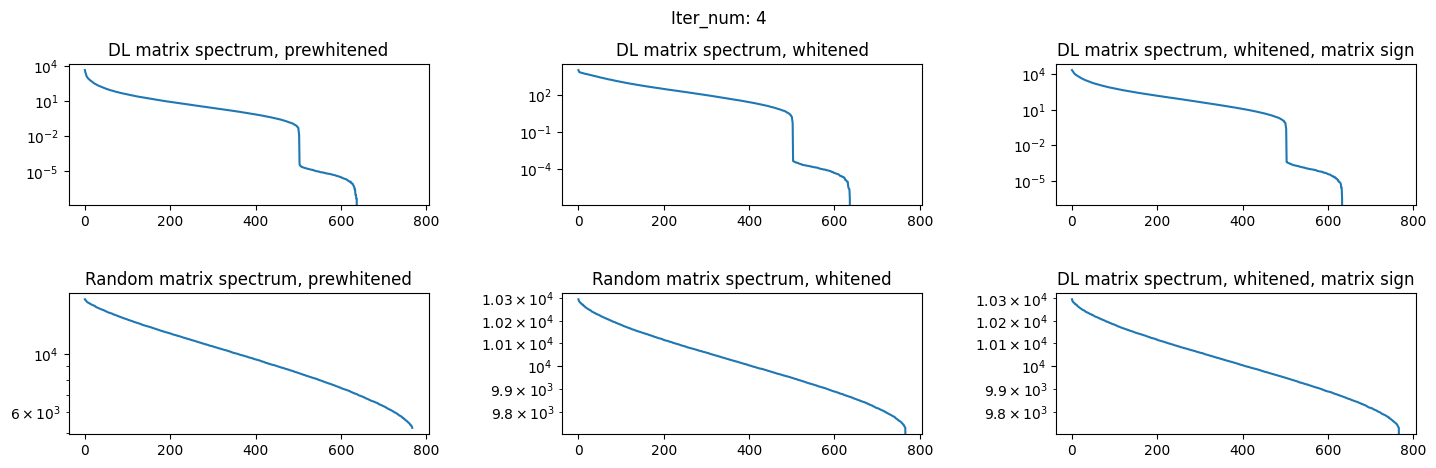

In [76]:
import matplotlib.pyplot as plt

iter = 4
fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(15, 5))

lineplot(singvals(A), ax=ax1[0],)
ax1[0].set_title("DL matrix spectrum, prewhitened")
ax1[0].set_yscale('log')
lineplot(singvals(wh1(A, iter, )), ax=ax1[1])
ax1[1].set_title("DL matrix spectrum, whitened")
ax1[1].set_yscale('log')
lineplot(singvals(wh3(A, iter, )), ax=ax1[2])
ax1[2].set_title("DL matrix spectrum, whitened, matrix sign")
ax1[2].set_yscale('log')



lineplot(singvals(B), ax=ax2[0],)
ax2[0].set_title("Random matrix spectrum, prewhitened")
ax2[0].set_yscale('log')
lineplot(singvals(wh1(B, iter,)), ax=ax2[1])
ax2[1].set_title("Random matrix spectrum, whitened")
ax2[1].set_yscale('log')
lineplot(singvals(wh3(B, iter, )), ax=ax2[2])
ax2[2].set_title("DL matrix spectrum, whitened, matrix sign")
ax2[2].set_yscale('log')


plt.tight_layout(pad=3.0)
fig.suptitle(f"Iter_num: {iter}")

Text(0.5, 0.98, 'Iter_num: 6')

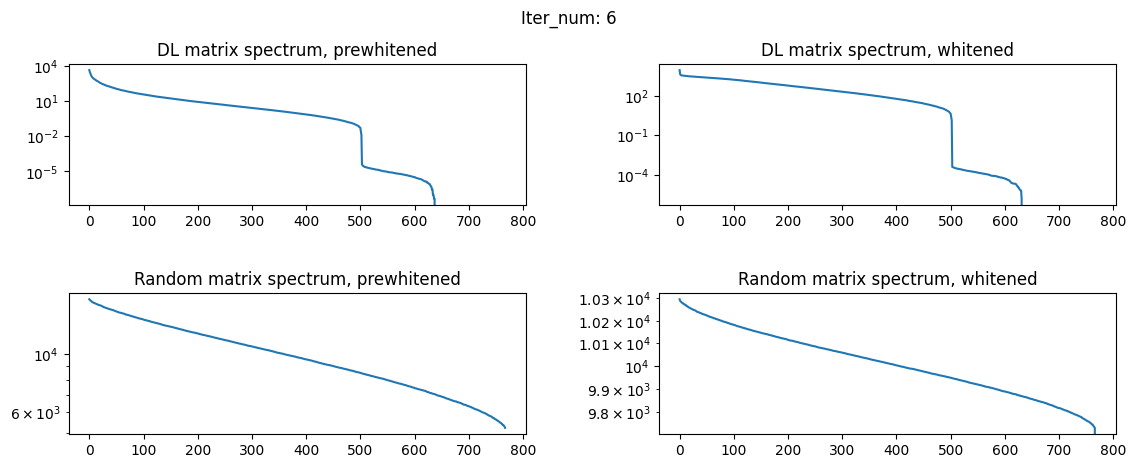

In [77]:
import matplotlib.pyplot as plt

iter = 6
diag = False
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 5))

lineplot(singvals(A), ax=ax1[0],)
ax1[0].set_title("DL matrix spectrum, prewhitened")
ax1[0].set_yscale('log')
lineplot(singvals(wh1(A, iter, diag)), ax=ax1[1])
ax1[1].set_title("DL matrix spectrum, whitened")
ax1[1].set_yscale('log')

lineplot(singvals(B), ax=ax2[0],)
ax2[0].set_title("Random matrix spectrum, prewhitened")
ax2[0].set_yscale('log')
lineplot(singvals(wh1(B, iter, diag)), ax=ax2[1])
ax2[1].set_title("Random matrix spectrum, whitened")
ax2[1].set_yscale('log')

plt.tight_layout(pad=3.0)
fig.suptitle(f"Iter_num: {iter}")

In [57]:

iter = 3
singvals(A).sum(), singvals(wh1(A, iter, )), singvals(wh1(A, iter, )).sum(), eff_rank(A), eff_rank(wh1(A, iter, ))


(tensor(32750.3867),
 tensor([ 5.1100e+02,  5.1098e+02,  5.1060e+02,  5.0664e+02,  5.0011e+02,
          4.8813e+02,  4.7898e+02,  4.6857e+02,  4.5565e+02,  4.4699e+02,
          4.3582e+02,  4.2468e+02,  4.1472e+02,  3.9775e+02,  3.8922e+02,
          3.7936e+02,  3.7131e+02,  3.5597e+02,  3.4329e+02,  3.3298e+02,
          3.2261e+02,  3.1294e+02,  2.9705e+02,  2.9175e+02,  2.7999e+02,
          2.7582e+02,  2.6561e+02,  2.6107e+02,  2.5097e+02,  2.4062e+02,
          2.3322e+02,  2.2749e+02,  2.2315e+02,  2.1476e+02,  2.1050e+02,
          2.0477e+02,  1.9702e+02,  1.9257e+02,  1.8717e+02,  1.8394e+02,
          1.7932e+02,  1.7417e+02,  1.6900e+02,  1.6322e+02,  1.5765e+02,
          1.5337e+02,  1.5064e+02,  1.4692e+02,  1.4501e+02,  1.4027e+02,
          1.3450e+02,  1.3167e+02,  1.2864e+02,  1.2597e+02,  1.2292e+02,
          1.2069e+02,  1.1735e+02,  1.1455e+02,  1.0965e+02,  1.0843e+02,
          1.0717e+02,  1.0352e+02,  1.0178e+02,  1.0001e+02,  9.8007e+01,
          9.6070e

In [60]:

iter = 15
singvals(A).sum(), singvals(wh3(A, iter, )), singvals(wh3(A, iter, )).sum(), eff_rank(A), eff_rank(wh3(A, iter, ))


(tensor(32750.3867),
 tensor([ 6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,
          6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,
          6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,
          6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,
          6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,
          6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,  6.7268e+01,
          6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,
          6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,
          6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,
          6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,
          6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,
          6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,
          6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,  6.7267e+01,
          6.7267e

In [142]:
# diag_init, 1 iter
iter = 3
diag = False
singvals(B).sum(), singvals(wh1(B, iter, diag)), singvals(wh1(B, iter, diag)).sum(), eff_rank(B), eff_rank(wh1(B, iter, diag))

(tensor(1535440.3750),
 tensor([1999.0137, 1999.0117, 1999.0098, 1999.0087, 1999.0071, 1999.0065,
         1999.0059, 1999.0048, 1999.0046, 1999.0046, 1999.0042, 1999.0037,
         1999.0035, 1999.0031, 1999.0027, 1999.0022, 1999.0021, 1999.0020,
         1999.0017, 1999.0016, 1999.0016, 1999.0015, 1999.0012, 1999.0012,
         1999.0012, 1999.0012, 1999.0011, 1999.0011, 1999.0010, 1999.0009,
         1999.0007, 1999.0007, 1999.0005, 1999.0005, 1999.0004, 1999.0002,
         1999.0002, 1999.0002, 1999.0002, 1999.0001, 1999.0000, 1999.0000,
         1998.9999, 1998.9998, 1998.9998, 1998.9998, 1998.9996, 1998.9996,
         1998.9995, 1998.9995, 1998.9995, 1998.9995, 1998.9993, 1998.9993,
         1998.9993, 1998.9991, 1998.9991, 1998.9990, 1998.9989, 1998.9988,
         1998.9988, 1998.9988, 1998.9985, 1998.9985, 1998.9985, 1998.9985,
         1998.9983, 1998.9982, 1998.9982, 1998.9978, 1998.9978, 1998.9976,
         1998.9973, 1998.9973, 1998.9971, 1998.9971, 1998.9969, 1998.9968,
  